<a href="https://colab.research.google.com/github/AguaClara/CEE4520/blob/master/Unit_Process_Designs/Coagulant_Dose_FM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install aguaclara

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 204kB 12.6MB/s 
  Created wheel for aguaclara: filename=aguaclara-0.2.3-cp36-none-any.whl size=99459 sha256=f99f4f8c56bb08c4b8de108f132ea3ba1d6b9d55e148c9e391e74ed9826d9dd4
  Stored in directory: /root/.cache/pip/wheels/da/f3/b6/a4648b3b3bc239e7953e74a2dee9f21c07d1b1e1f65cb86311
Successfully built aguaclara


In [44]:
##import
import aguaclara as ac
from aguaclara.core.units import unit_registry as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve 

## constants & variables
DiamTube = 4 * u.inch
Temp = 10 * u.degC
Time = 7 * u.min
EnergyDis = 40 * u.cm * u.gravity / Time
NatOrgMat = ac.HumicAcid
material = ac.Clay
coag = ac.PACl
FittingParam = 0.13
RatioHeightDiameter = 0.2



72 nanometer
[44.1 44.1 44.1 44.1 44.1 44.1 44.1 44.1 44.1 44.1 44.1 44.1 44.1 44.1 44.1 44.1 44.1 44.1 44.1 28.65 15.55 10.6 8.084 6.595 5.621 4.94 4.44 4.059 3.761 3.521 3.325 3.162 3.024 2.907 2.806 2.718 2.641 2.573 2.513 2.459 2.411 2.367 2.328 2.292 2.259 2.229 2.202 2.177 2.153 2.132] milligram / liter
44.87 milligram / liter
The coagulant dose is 13.21 milligram / liter


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


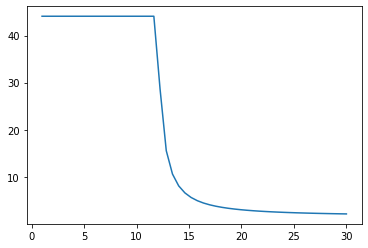

In [45]:
ConcClay = 30 * u.NTU
Color = 400
True_Color = Color - ConcClay*7.5/(u.NTU)
TOC = True_Color / 7.8 * u.mg/u.L
ConcNatOrgMat = TOC*2
ConcAl = np.linspace(1,30) * u.mg/u.L
# ConcAl = 20 * u.mg/u.L
print(NatOrgMat.Diameter.to(u.nm))

Gracias_yellow = ac.Material('Gracias_yellow',36*u.nm,900 * u.kg/u.m**3,900 * u.g/u.mol)


Eff_Turbidity = (ac.invp(ac.pc_viscous(EnergyDis, Temp, Time, DiamTube, ConcClay, ConcAl, ConcNatOrgMat, Gracias_yellow, coag, material, FittingParam, RatioHeightDiameter)) * ConcClay)
reversed_Eff_Turbidity = Eff_Turbidity[::-1]
reversed_ConcAl = ConcAl[::-1]

print(Res_Turbidity)
print(ConcNatOrgMat)

plt.plot(ConcAl.to(u.mg/u.L),Res_Turbidity.to(u.mg/u.L))


Target_Turbidity = (10 * u.NTU)
Al_Dose = np.interp(Target_Turbidity, reversed_Eff_Turbidity, reversed_ConcAl)
print('The coagulant dose is',Al_Dose)


In [40]:
x = np.linspace(0,5)
y = 3*x
Target_y = 6
my_x = np.interp(Target_y, y, x)
print(my_x)

1.9999999999999998
